# Compering the Hierarchical and Flat Structre 

In [20]:
import numpy as np
from sklearn import tree
from sklearn import preprocessing
import copy
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import scipy as sp


def get_labels(_data):
    _label = _data["trans_mode"]
    _data = _data.drop("trans_mode", axis=1)
    return _data, _label


def get_labels1(_data):
    _label = _data["trans_mode"]
    _label_lev1 = _data["lev1"]
    _data = _data.drop("trans_mode", axis=1)
    _data = _data.drop("lev1", axis=1)
    return _data, _label, _label_lev1


# Read data of features


# split the data by the trans_mode
def split_class(df):
    bus = pd.DataFrame(df[df["trans_mode"] == 'bus'])
    car = pd.DataFrame(df[df["trans_mode"] == 'car'])
    walk = pd.DataFrame(df[df["trans_mode"] == 'walk'])
    taxi = pd.DataFrame(df[df["trans_mode"] == 'taxi'])
    subway = pd.DataFrame(df[df["trans_mode"] == 'subway'])
    train = pd.DataFrame(df[df["trans_mode"] == 'train'])
    return walk, bus, car, taxi, subway, train


# contact the data and change the trans_mode to new one
def change_labels(_class_data, old_class, _class_names):
    for c in old_class:
        _class_data.loc[_class_data["trans_mode"] == c, ("trans_mode")] = _class_names
    return _class_data


def change_labels1(_class_data, old_class, _class_names):
    for c in old_class:
        _class_data.loc[_class_data["trans_mode"] == c, ("lev1")] = _class_names
    return _class_data


# bus, car, walk, taxi, subway, train = split_class(_all_data)
# car_taxi_bus = create_data_model([bus, car, taxi], "ctb")
# subway_train = create_data_model([subway, train], "sub_train")
#  creat new column to help for hierarchical the classes
def create_hierarchical_indexing(_data):
    df = _data
    df["lev1"] = pd.Series(df["trans_mode"])
    df = change_labels1(_data, ["car", "taxi", "bus"], "ctb")
    df = change_labels1(df, ["train", "subway"], "sub_train")
    return df

# method for fit the data in models hierarchical the data 
def hierarchical_fit(model, indexes, _data):
    df = create_hierarchical_indexing(_data)
    _dt, _label, _lab_lev1 = get_labels1(df)

    model1 = copy.copy(model)
    model2_1 = copy.copy(model)
    model2_2 = copy.copy(model)

    indexes_level2_1 = [True if i == "ctb" else False for i in _lab_lev1]
    indexes_level2_2 = [True if i == "sub_train" else False for i in _lab_lev1]

    model1.fit(_dt.iloc[indexes], _lab_lev1.iloc[indexes])
    # print(_label.loc[indexes_level2_1])
    model2_1.fit(_dt.loc[indexes_level2_1], _label.loc[indexes_level2_1])
    model2_2.fit(_dt.loc[indexes_level2_2], _label.loc[indexes_level2_2])
#     the models for the strurter for each level
    return [model1, model2_1, model2_2]


def hierarchical_predict(_models, indexes, _data):
    model1 = _models[0]
    model2_1 = _models[1]
    model2_2 = _models[2]
    df = create_hierarchical_indexing(_data)
    _dt, _label, _lab_lev1 = get_labels1(df)

    prediction_1 = model1.predict(_dt)

    indexes_level2_1 = [True if i == "ctb" else False for i in _lab_lev1]
    indexes_level2_2 = [True if i == "sub_train" else False for i in _lab_lev1]

    prediction_2 = model2_1.predict(_dt)
    prediction_3 = model2_2.predict(_dt)
    prediction = prediction_1
    prediction[indexes_level2_1] = prediction_2[indexes_level2_1]
    prediction[indexes_level2_2] = prediction_3[indexes_level2_2]
    return accuracy_score(_label.loc[indexes], prediction[indexes])

# cross validation method for the project
def comper_models(_models, _models_name, _all_data_original):
    skf = StratifiedKFold(n_splits=10)
    accuracies_hierarchical = list()
    accuracies_flat = list()
    for model in _models:
        _all_data = copy.copy(_all_data_original)
        _data, _label = get_labels(_all_data)
        acc_hierarchical = list()
        acc_flat = list()
        for trains, test in skf.split(_data, _label):
            _hierarchical_models = hierarchical_fit(model, trains, _all_data)
            acc_hierarchical.append(hierarchical_predict(_hierarchical_models, test, _all_data))
            model.fit(_data.loc[trains], _label[trains])
            acc_flat.append(accuracy_score(_label.loc[test], model.predict(_data.loc[test])))
        
        accuracies_hierarchical.append(acc_hierarchical)
        accuracies_flat.append(acc_flat)
        print("Done")
    return pd.DataFrame(data={"model_name": _models_name, "model": _models
        , "acc_hierarchical": accuracies_hierarchical, "acc_flat": accuracies_flat})



In [23]:

all_data = pd.read_csv(r'resultFinal.csv')
models_name = ["DTC", "Random_Forest"]
models_list = [tree.DecisionTreeClassifier(), RandomForestClassifier()]
df_result = comper_models(models_list, models_name, all_data)



Done
Done


# calculate the t-test

In [24]:
t_test_58_fd = 0.05

x = df_result.loc[0]
y = df_result.loc[1]


print("Hierarchical")
statistic, p_val = sp.stats.ttest_ind((x["acc_hierarchical"]), (y["acc_hierarchical"]), equal_var=True)
print('p_val', p_val, 'statistic', statistic)
if p_val >= t_test_58_fd:
    print('the mean model ', x["model_name"],
          'is identical to mean of model', y["model_name"])
else:
    print('the mean of model ', x["model_name"],
          'is not identical to mean of model', y["model_name"])
print()
print("Flat")
statistic, p_val = sp.stats.ttest_ind((x["acc_flat"]), (y["acc_flat"]), equal_var=True)
print('p_val', p_val, 'statistic', statistic)
if p_val >= t_test_58_fd:
    print('the mean model ', x["model_name"],
          'is identical to mean of model', y["model_name"])
else:
    print('the mean of model ', x["model_name"],
          'is not identical to mean of model', y["model_name"])

Hierarchical
p_val 0.00097988283406 statistic -3.93076624398
the mean of model  DTC is not identical to mean of model Random_Forest

Flat
p_val 0.000528543268696 statistic -4.20816659712
the mean of model  DTC is not identical to mean of model Random_Forest


In [25]:
import matplotlib.pyplot as plt
def plot_2_axis(data_x, label_x, data_y1, label_y1, data_y2, label_y2):
    fig, ax = plt.subplots()
    ax.plot(data_x, data_y1, label=label_y1)
    ax.set_ylabel(label_y1)
    ax2 = ax.twinx()
    ax2.plot(data_x, data_y2, label=label_y2, color='r')
    ax2.set_ylabel(label_y2)
    lines = ax.get_lines() + ax2.get_lines()
    ax.legend(lines, [line.get_label() for line in lines])
    plt.title(label_x)
    plt.show()

# Plot DTC and Random forest accuracy for hierarchical Structre

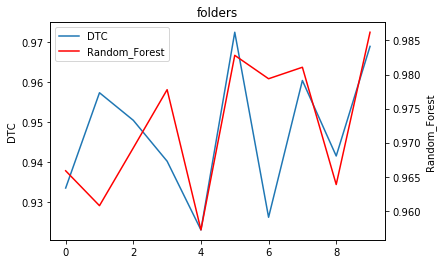

10


In [26]:
plot_2_axis(range(10), "folders", x["acc_hierarchical"],  x["model_name"], y["acc_hierarchical"],  y["model_name"])

print(len(x["acc_hierarchical"]))

# Plot DTC and Random forest accuracy for falt Structre

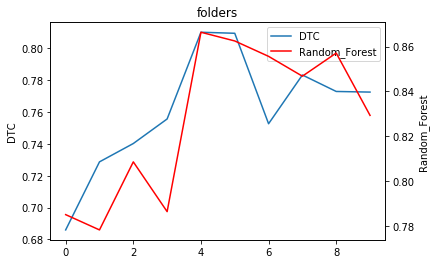

In [17]:
plot_2_axis(range(10), "folders", x["acc_flat"],  x["model_name"], y["acc_flat"],  y["model_name"])